# Information on Time series

The Information Bottleneck principle can also be used to extract minimal sufficient representation of Markov Processes.
The `torch_mist` package contains an implementation of the [Time-Lagged Information Bottleneck](https://arxiv.org/abs/2309.07200) model, which can be used to isolate time processes at a specified time scale $\tau$.

In this example we will consider a 2D time process characterized by two non-linearly mixed components: one fast, and one slow. We are interested in creating a 1D representation of the process that captures the slow dynamics only.

The [DeepTime](https://deeptime-ml.github.io/latest/index.html) package is used to produce the data. Please install is using
```
! pip install deeptime
```

Text(0.5, 0, '$x$')

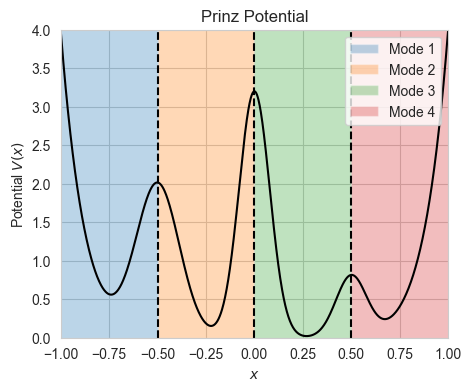

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from deeptime.data import prinz_potential
import numpy as np

# We instantiate a Prinz Potential, which consists of 4 modes
process = prinz_potential()

# Plot the potential from -1 to 1
f, ax = plt.subplots(1,1, figsize=(5,4))

x = np.linspace(-1.0,1.0, 1000)
plt.plot(x, process.potential(x), color='k')

# Energy barriers are plotted with dashed vertical lines. 
# For visualization purpose, we associate each region with a different color.
thresholds = np.array([-0.5,0,0.5])
prev_thresh = -1
for i,t in enumerate(thresholds):
    plt.axvline(t, ls='--', color='k')
    plt.fill_between([prev_thresh, t], [0,0], [4,4], alpha=0.3, label=f'Mode {i+1}')
    prev_thresh = t
    
plt.fill_between([prev_thresh, 1], [0,0], [4,4], alpha=0.3, label=f'Mode 4')
ax.set_title("Prinz Potential")
ax.legend()
ax.set_ylim(0,4)
ax.set_xlim(-1,1)
ax.set_ylabel("Potential $V(x)$")
ax.set_xlabel("$x$")

(0.0, 5248.95)

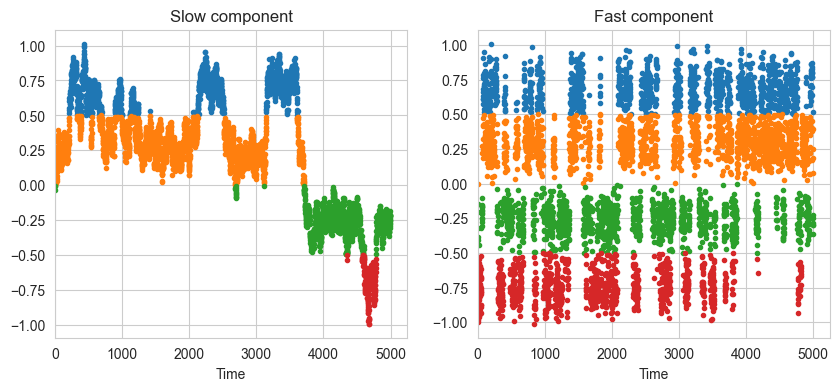

In [29]:
# Starting point for the temporal trajectories
start = np.zeros([2,1])
# Generate trajectories of 100K time-steps
traj_length = 100000

# We generate two trajectories with Langevin Dynamics on the Prinz potential
# The timesteps for the slow trajectory are separated by 5 steps
slow_traj = prinz_potential(h=1e-4, n_steps=5, damping=1).trajectory(start[0], traj_length, n_jobs=1).astype(np.float32)
# While for the fast trajectory, steps are 160 apart
fast_traj = prinz_potential(h=1e-4, n_steps=160, damping=1).trajectory(start[1], traj_length, n_jobs=1).astype(np.float32)

# We can visualize them colored by the respective modes
f, ax = plt.subplots(1,2, figsize=(10,4))

# Discrete slow and fast modes
slow_modes = (slow_traj<thresholds.reshape(1,-1)).sum(-1)
fast_modes = (fast_traj<thresholds.reshape(1,-1)).sum(-1)

# Plot the slow trajectory
n_steps = 5000
for i in range(4):
    mask = slow_modes[:n_steps]==i
    ax[0].scatter(np.arange(n_steps)[mask], slow_traj[:n_steps][mask], label='Slow Component', marker='.')
ax[0].set_title("Slow component")
ax[0].set_xlabel('Time')
ax[0].set_xlim(0,)

# And the fast one
for i in range(4):
    mask = fast_modes[:n_steps]==i
    ax[1].scatter(np.arange(n_steps)[mask], fast_traj[:n_steps][mask], label='Slow Component', marker='.')
ax[1].set_title("Fast component")
ax[1].set_xlabel('Time')
ax[1].set_xlim(0,)

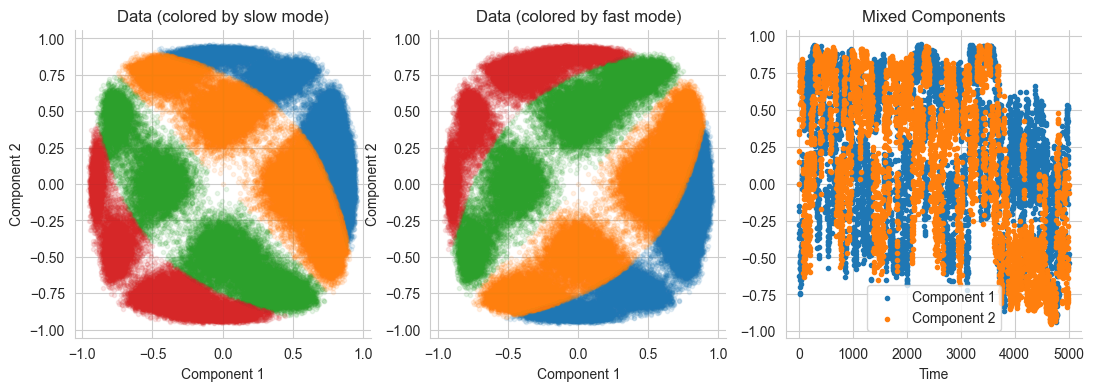

In [36]:
# We mix the two trajectories with a linear transformation and a tanh non-linearity to entangle the two processes
mixed_traj = np.concatenate([
    (slow_traj + fast_traj).reshape(-1, 1),
    (slow_traj - fast_traj).reshape(-1, 1),
], -1)
mixed_traj = np.tanh(mixed_traj)

# Plot the whole trajectories after mixing
f, ax = plt.subplots(1,3, figsize=(13,4))

# Colored by the slow modes
ax[0].set_title('Data (colored by slow mode)')
for i in range(4):
    ax[0].scatter(x=mixed_traj[slow_modes==i,0], y=mixed_traj[slow_modes==i,1], marker='.', alpha=0.1)
ax[0].set_xlabel('Component 1')
ax[0].set_ylabel('Component 2')

# Colored by the fast modes
ax[1].set_title('Data (colored by fast mode)')
for i in range(4):
    ax[1].scatter(x=mixed_traj[fast_modes==i,0], y=mixed_traj[fast_modes==i,1], marker='.', alpha=0.1)
ax[1].set_xlabel('Component 1')
ax[1].set_ylabel('Component 2')

# Visualize the mixed components over time
ax[2].set_title("Mixed Components")
ax[2].scatter(np.arange(n_steps), mixed_traj[:n_steps,0], label='Component 1', marker='.')
ax[2].scatter(np.arange(n_steps), mixed_traj[:n_steps,1], label='Component 2', marker='.')
ax[2].set_xlabel('Time')
ax[2].legend()

sns.despine();

We can use the `torch_mist` package to determine how the mutual information between elements of the trajectory evolves with time.
The `estimate_temporal_mi` utility allows us to easily estimate mutual information between elements of the sequence that are $\tau_i$ apart for multiple $\tau_i$ at once. 
The expected value of mutual information $I(x_t;x_{t+\tau})$ is referred to as **Auto Information** and it's abbrieviated with $AI(x_t;\tau)$:

$$
AI(x_t;\tau) = \mathbb{E}_t[I(x_t;x_{t+\tau})]
$$

In [34]:
from torch_mist.utils.estimation import estimate_temporal_mi

trajectories = {
    "fast": fast_traj,
    "slow": slow_traj,
    "mixed": mixed_traj
}

# Time scales at which we want to measure mutual information (from 1 to 2^13) 
lagtimes = 2**np.arange(13).astype(np.int32)

estimation_params = dict(
    batch_size=128,
    hidden_dims=[256, 128],
    max_epochs=20,
    neg_samples=8,
    patience=2,
    verbose=False,
)

results = {}

# For each trajectory
for name, trajectory in trajectories.items():
    # We estimate the mutual information at the specified scales (using the default SMILE estimator)
    # (This may require a few minutes)
    temporal_mutual_information, train_log = estimate_temporal_mi(
        lagtimes=lagtimes,
        data=trajectory,
        **estimation_params
    )
    
    results[name] = temporal_mutual_information.values()


[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.


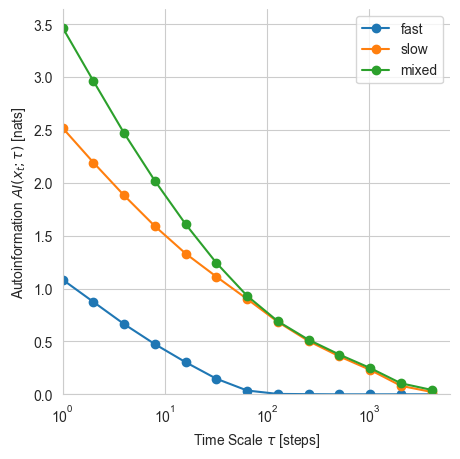

In [35]:
# Plot the value of Autoinformation over time
f, ax = plt.subplots(1,1, figsize=(5,5))

for name, mi_values in results.items():
    plt.plot(lagtimes, mi_values, marker='o', label=name)
plt.xscale('log')
plt.legend()
plt.ylim(0,)
plt.xlim(1,)
plt.xlabel("Time Scale $\\tau$ [steps]")
plt.ylabel("Autoinformation $AI(x_t;\\tau)$ [nats]")
sns.despine()

Autoinformation is a non-increasing function for Markov processes, which indicates how information propagates in time. A small value of Autoinformation indicate marginally independent samples. This can be used, for example, to determine the relaxation time of the process or to estimate the burn-in to produce i.i.d. Markov Chain Monte Carlo samples.

The Autoinformation for the mixed trajectories corresponds to the sum of the two autoinformations. This is because the two trajectories are independent and mixed through an invertible non-linear function: 
$$AI(x_t^{mixed};\tau) = AI(x_t^{slow};\tau) + AI(x_t^{fast};\tau)$$
Note that at the time scale $\tau=64$ almost the entirety of the trajectory information is determined by the slow trajectory. 

## Time-lagged InfoMax

One strategy to learn a representation that preserve mutual information at the temporal scale of interest consists in maximizing the autoinformation between the representation at the same temporal scale.
We refer to this objective as Temporal InfoMax `TInfoMax`:
$$
\mathcal{L}_{T-InfoMax}(\tau;\theta) = -AI(z_t;\tau),
$$
in which $\theta$ refers to the parameters of the encoder model.

The `torch_mist` package contains an easy-to-use implementation of `TInfoMax`, which provides the same interface of other decomposition methods.
In this example, we will a 2-dimensional representation $z_t$.

In [37]:
from torch_mist.decomposition import TInfoMax

# Define the time scale of interest (this is usually problem dependent)
interesting_timescale=64

# Instantiate the TIB model
projection = TInfoMax(n_dim=2, lagtime=interesting_timescale)

# Fit the data
projection.fit(mixed_traj, max_epochs=10, verbose=True);

[Info]: batch_size is not specified, using batch_size=64 by default.
[Info]: patience is not specified, using patience=1 (~2% of training epochs) by default.


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1406 [00:00<?, ?it/s]

Loading the weights saved at iteration 8436


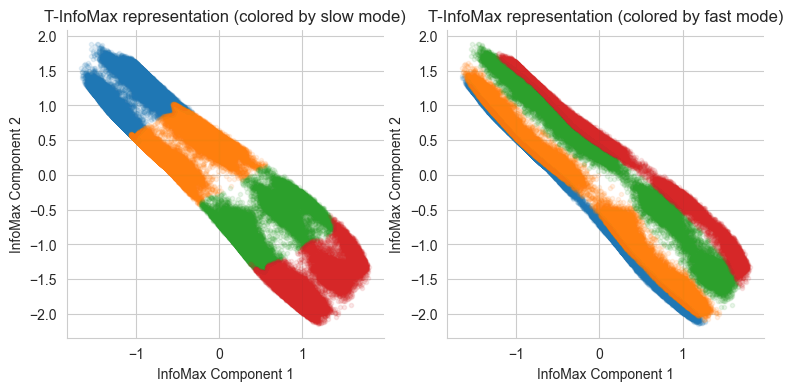

In [41]:
representations = {}

# Encode the data into the representation space
representations['T-InfoMax'] = projection.transform(mixed_traj)

# And visualize it
f, ax = plt.subplots(1,2, figsize=(9,4))
for i in range(4):
    ax[0].scatter(
        x=representations['T-InfoMax'][slow_modes==i,0], 
        y=representations['T-InfoMax'][slow_modes==i,1], 
        marker='.', alpha=0.1
    )
    
    ax[1].scatter(
        x=representations['T-InfoMax'][fast_modes==i,0], 
        y=representations['T-InfoMax'][fast_modes==i,1], 
        marker='.', alpha=0.1
    )
    
ax[0].set_title("T-InfoMax representation (colored by slow mode)")
ax[0].set_xlabel("InfoMax Component 1")
ax[0].set_ylabel("InfoMax Component 2")

ax[1].set_title("T-InfoMax representation (colored by fast mode)")
ax[1].set_xlabel("InfoMax Component 1")
ax[1].set_ylabel("InfoMax Component 2")

sns.despine();

## Time-lagged Information Bottleneck
Instead of focusing solely on minimality, the Time-lagged Information Bottleneck objective, aims to produce the minimal (simplest) amongst the T-InfoMax representations.
The `TIB` objective consists of an information maximization component, which takes care of capturing the relevant dynamics at the specified temporal scale; and a regularization term, which is responsible for removing superfluous information:
$$
\mathcal{L}_{TIB}(\tau;\theta,\phi) = -AI(z_t;\tau) + \beta \overbrace{KL(\underbrace{p_\theta(z_{t+\tau}|x_{t+\tau})}_{\text{Encoding}}||\underbrace{q_\phi(z_{t+\tau}|z_{t})}_{\text{Transition}})}^{\text{Regularization}},
$$
in which $\tau$ determines the temporal scale of interest, and $\beta$ the regularization strength.

In [42]:
from torch_mist.decomposition import TIB

# Instantiate the TIB model
projection = TIB(n_dim=2, beta=0.05, lagtime=64, transition_params={'transform_name': 'conditional_linear'})

# Fit the data
projection.fit(mixed_traj, max_epochs=10, verbose=True);

[Info]: batch_size is not specified, using batch_size=64 by default.
[Info]: patience is not specified, using patience=1 (~2% of training epochs) by default.


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1406 [00:00<?, ?it/s]

Loading the weights saved at iteration 2812


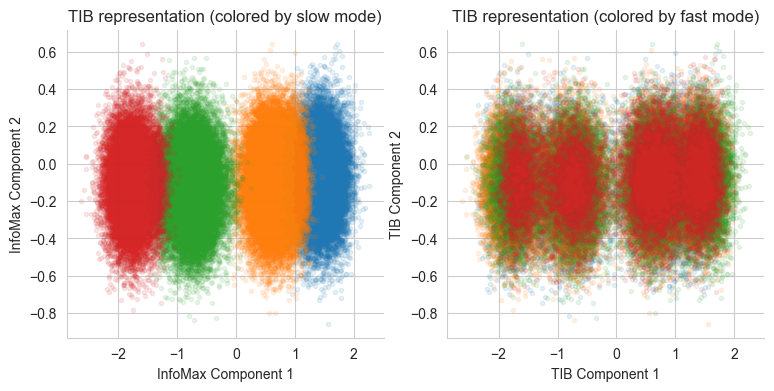

In [43]:
# Sample the representations from p(z_t|x_t)
projection.stochastic_transform=True
representations['TIB'] = projection.transform(mixed_traj)

# And visualize it
f, ax = plt.subplots(1,2, figsize=(9,4))
for i in range(4):
    ax[0].scatter(
        x=representations['TIB'][slow_modes==i,0], 
        y=representations['TIB'][slow_modes==i,1], 
        marker='.', alpha=0.1
    )
    
    ax[1].scatter(
        x=representations['TIB'][fast_modes==i,0], 
        y=representations['TIB'][fast_modes==i,1], 
        marker='.', alpha=0.1
    )
    
ax[0].set_title("TIB representation (colored by slow mode)")
ax[0].set_xlabel("InfoMax Component 1")
ax[0].set_ylabel("InfoMax Component 2")

ax[1].set_title("TIB representation (colored by fast mode)")
ax[1].set_xlabel("TIB Component 1")
ax[1].set_ylabel("TIB Component 2")

sns.despine();

We can now compare the information content of the trajectory representations for the same temporal scales to determine which components are preserved, and which ones are discarded:

In [44]:
#For each representation trajectory
for name, trajectory in representations.items():
    # We estimate the mutual information at the specified scales (using the default SMILE estimator)
    temporal_mutual_information, train_log = estimate_temporal_mi(
        lagtimes=lagtimes,
        data=trajectory,
        **estimation_params
    )
    
    results[name] = temporal_mutual_information.values()

[Warning]: using data to estimate the value of mutual information. Please specify test_data.
[Warning]: using data to estimate the value of mutual information. Please specify test_data.


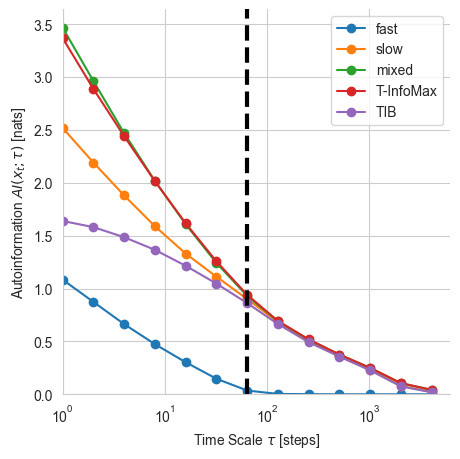

In [46]:
# Plot the value of Autoinformation over time
f, ax = plt.subplots(1,1, figsize=(5,5))

for name, mi_values in results.items():
    plt.plot(lagtimes, mi_values, marker='o', label=name)
    
# Timescale of interest
plt.axvline(x=interesting_timescale, color='k', ls='--', linewidth=3)
    
plt.xscale('log')
plt.legend()
plt.ylim(0,)
plt.xlim(1,)
plt.xlabel("Time Scale $\\tau$ [steps]")
plt.ylabel("Autoinformation $AI(x_t;\\tau)$ [nats]")
sns.despine()

Both the T-InfoMax and TIB representations capture the maximum amount of information at the timescale of interest.
However, the addition of the minimality term drastically reduces the amount of superfluous information captured into the representation. As a result, the representation is much simpler and transitions are easier to model in the TIB representation space.